<a href="https://colab.research.google.com/github/gustapfp/2025.2-G4-bovenau-protalent/blob/main/src/experiments/jupyter/yolo_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yolo Training Model
This Jupyter Notebook its used for training a Yolo Model for Welding Detection.

# 1. Introduction

This notebook uses [Ultralytics](https://docs.ultralytics.com/) to train YOLO11, YOLOv8, or YOLOv5 object detection models with a custom dataset. At the end of this Colab, you'll have a custom YOLO model that you can run on your PC, phone, or edge device like the Raspberry Pi.

<p align=center>
<img src="https://s3.us-west-1.amazonaws.com/evanjuras.com/img/yolo-model-demo.gif" height="360"><br>
<i>Custom YOLO candy detection model in action!</i>
</p>

## 1.1 Verify NVIDIA GPU Availability

Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting one of the GPU options in the Hardware accelerator section. Click Play on the following code block to verify that the NVIDIA GPU is present and ready for training.

In [1]:
!nvidia-smi

Wed Oct 15 11:48:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Upload Images
Upload .zip folder into colab instance and them split the images

## 2.1  Split images into train and validation folders
At this point, whether you used Option 1, 2, or 3, you should be able to click the folder icon on the left and see your `archive.zip` file in the list of files. Next, we'll unzip `archive.zip` and create some folders to hold the images. Run the following code block to unzip the data.

In [3]:
!unzip -q /content/archive.zip -d /content/custom_data

Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

*   **Train**: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.

* **Test**: These images are used only after training is completed, to evaluate the model on unseen data and measure its generalization ability.


*   **Validation**: These images are used to check the model's performance at the end of each training epoch.

In each of these folders is a “images” folder and a “labels” folder, which hold the image files and annotation files respectively.

If the dataset doesn't have this folder structure already, run this Python script which will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder. Run the following code block to download and execute the scrpt.

*The python script was made by: Evan Juras, [EJ Technology Consultants](https://ejtech.io)*

In [ ]:
# Remove the comment here:
# !wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
# Remove the comment here:
# !python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

# 3. Install the Requirements
Before training or testing YOLO models, you need to install the Ultralytics package and its dependencies. This can be done directly from PyPI:

In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.1 MB/s eta 0:00:00




Once installed, you can check if everything is working by importing the package and printing its version:

The `ultralytics.checks()` command verifies that your environment (CUDA, PyTorch, and dependencies) is correctly set up for training and inference.

In [6]:
import ultralytics
ultralytics.checks()


Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.8/112.6 GB disk)


*Tip: If you are working in Google Colab, the installation will only persist while the runtime is active. You’ll need to run the installation cell each time you restart the runtime.*

# 4. Creating the Training Configuration File

There’s one last step before we can run training: we need to create the **Ultralytics training configuration YAML file**.

This file tells YOLO:

* Where the **train**, **validation**, and **test** datasets are located.
* Which **classes** the model should learn.

Ultralytics expects a `data.yaml` file with paths to your dataset folders and a list of class names.

Run the code block below to automatically generate the `data.yaml` configuration file.

Make sure you already have a **label map file** located at:

```
custom_data/classes.txt
```

If you used **Label Studio** or one of the provided datasets, this file should already exist.
If you assembled the dataset manually, you may need to create `classes.txt` yourself, with one class name per line.

In [ ]:
# import os

# # Path to your dataset and classes file
# dataset_path = "/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset"
# classes_file = os.path.join(dataset_path, "classes.txt")

# # Read classes from classes.txt
# with open(classes_file, "r") as f:
#     classes = [line.strip() for line in f.readlines() if line.strip()]

# # Build YAML content
# yaml_content = f"""
# # Ultralytics YOLO dataset configuration
# path: {dataset_path}  # root dataset path

# train: {os.path.join(dataset_path, "train/images")}
# val: {os.path.join(dataset_path, "valid/images")}
# test: {os.path.join(dataset_path, "test/images")}

# names:
# """

# for i, cls in enumerate(classes):
#     yaml_content += f"  {i}: {cls}\n"

# # Save to data.yaml
# yaml_file = os.path.join(dataset_path, "data.yaml")
# with open(yaml_file, "w") as f:
#     f.write(yaml_content)

# print(f"✅ data.yaml created at: {yaml_file}")
# print("--- data.yaml preview ---")
# print(yaml_content)


# 5. Training the Model

## 5.1 Training Model Size and Architecture

The figure bellow compares the performance of different YOLO versions and other object detection models using the COCO benchmark. The vertical axis represents validation accuracy (mAP50–95), while the horizontal axis shows inference latency (ms/image) on a TensorRT10 FP16 T4 GPU.

YOLO11 achieves the best balance between accuracy and speed, outperforming earlier YOLO versions (v5–v10) as well as alternative models like PP-YOLOE+, DAMO-YOLO, YOLOX, and EfficientDet.

Smaller models (e.g., YOLO11n, YOLO11s) offer lower latency and are suitable for real-time applications where speed is critical.

Larger models (e.g., YOLO11l, YOLO11x) provide higher accuracy at the cost of increased latency, making them more suitable for offline analysis or when computational resources are sufficient.

This trade-off between accuracy and inference speed allows practitioners to select the most appropriate YOLO model variant depending on their project requirements, whether prioritizing real-time performance or detection precision.

<p align=center>
<img src="https://raw.githubusercontent.com/ultralytics/assets/refs/heads/main/yolo/performance-comparison.png" height="360"><br>
<i>Yolo Models supported by Ultralytics</i>
</p>

## 5.2 Number of epochs (epochs)

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture. If the dataset has less than 200 images, a good starting point is 60 epochs. In our case the dataset has 835 images, we will start with 100.
## 5.3 Resolution (imgsz)

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. YOLO models are typically trained and inferenced at a 640x640 resolution. However, if you want your model to run faster or know you will be working with low-resolution images, try using a lower resolution like 480x480.

## 5.4 Training Stage - Model S

### 5.4.1 Traing 1
Parametes:
* Epochs=100
* Resolution=640x640

In [7]:
!yolo detect train model=yolo11s.pt data='/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml' name="base-trainer" epochs=100 imgsz=640



Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=base-trainer, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

## Train 2 - Base Yolo L

In [ ]:
!yolo detect train model=yolo11l.pt data='/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml' name="base-yolo-L" epochs=100 imgsz=640


Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=base-yolo-L, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overl


## Train 3 - Base Yolo X

In [ ]:
!yolo detect train model=yolo11x.pt data='/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml' name="base-yolo-X" epochs=100 imgsz=640

## Train 4 - Tune Resolution

In [ ]:
!yolo detect train model=yolo11s.pt data='/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml' epochs=120 imgsz=832 batch=16 multi_scale=True close_mosaic=20 patience=30 cos_lr=True name="train3-tuned-resolution"

## Train 5 - Generalization

In [ ]:
!yolo detect train model=yolo11s.pt data='/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml' epochs=120 imgsz=832 batch=16 \
  mosaic=0.7 mixup=0.15 copy_paste=0.2 \
  hsv_h=0.015 hsv_s=0.6 hsv_v=0.4 \
  translate=0.08 scale=0.5 shear=0.0 degrees=0.0 perspective=0.0 \
  flipud=0.0 fliplr=0.5 close_mosaic=20 name="Train4-generalization"


## Train 6 - Loss and Optimizer tweaks

In [ ]:
!yolo detect train model=yolo11s.pt data='/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml' epochs=120 imgsz=832 \
  optimizer=AdamW lr0=0.002 lrf=0.0002 weight_decay=0.0005 warmup_epochs=3 \
  box=7.5 cls=0.8 dfl=1.5 name="Train6-loss-optimizer-tweaks"

## Train 7 - Unified Trainers

In [ ]:
yolo detect train \
  model=yolo11s.pt \
  data="/content/The Welding Defect Dataset/data.yaml" \
  name="train5-unified-train-model-" \
  epochs=120 imgsz=832 batch=16 \
  patience=30 multi_scale=True cos_lr=True \
  mosaic=0.7 mixup=0.15 copy_paste=0.2 \
  hsv_h=0.015 hsv_s=0.6 hsv_v=0.4 \
  translate=0.08 scale=0.5 degrees=0.0 shear=0.0 perspective=0.0 \
  fliplr=0.5 flipud=0.0 close_mosaic=20 \
  optimizer=AdamW lr0=0.002 lrf=0.0002 weight_decay=0.0005 warmup_epochs=3 \
  box=7.5 cls=0.8 dfl=1.5 seed=0 workers=2

# 6. Test the Model

### 6.1 Test Train 1

 The commands below run the model on the images in the validation folder and then display the results for the first 10 images.

In [8]:
!yolo detect predict model=runs/detect/base-trainer/weights/best.pt source='/content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/valid/images' save=True

Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/176 /content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/valid/images/886d6ca3-1b242175-download_1_jpeg_jpg.rf.386935bff2eb78c24af0001e8b15401f.jpg: 640x640 3 Good Welds, 15.6ms
image 2/176 /content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/valid/images/Good-Welding-images_22_jpeg_jpg.rf.318c9d57367dca722350fe8d63b44591.jpg: 640x640 1 Good Weld, 15.6ms
image 3/176 /content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/valid/images/Not-perfect-welding-images_10_jpeg_jpg.rf.938705132c676bde86605b449fbfd55e.jpg: 640x640 3 Good Welds, 15.5ms
image 4/176 /content/custom_data/The Welding Defect Dataset/The Welding Defect Dataset/valid/images/Not-perfect-welding-images_17_jpeg_jpg.rf.64e46e84fb95dfb5e6eecc845629350c.jpg: 640x640 1 Bad Weld, 2 Defects, 15.

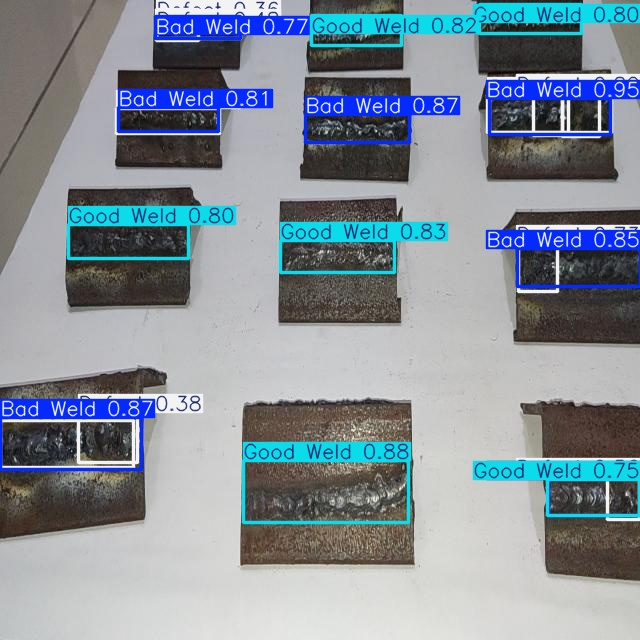

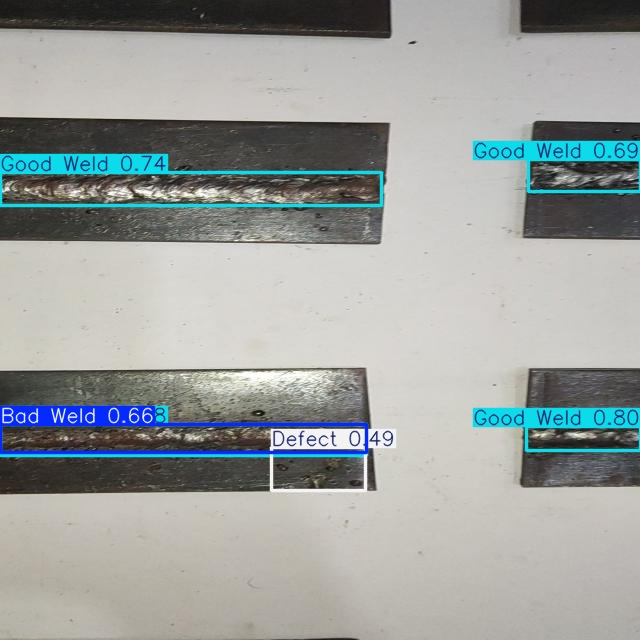

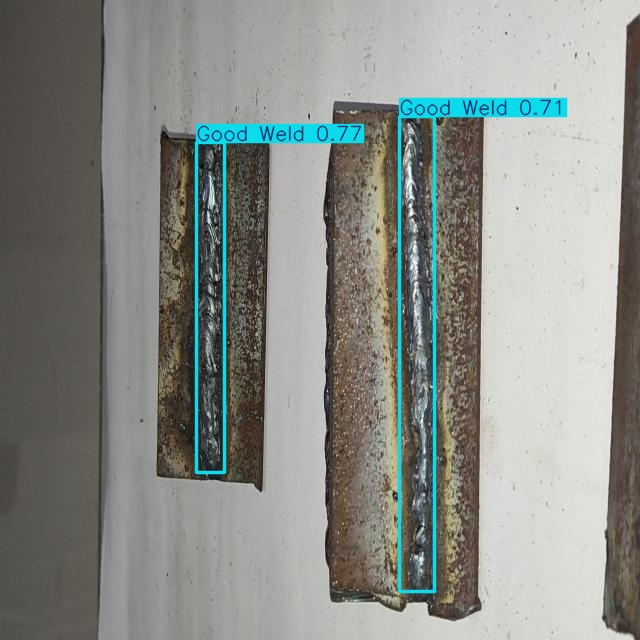

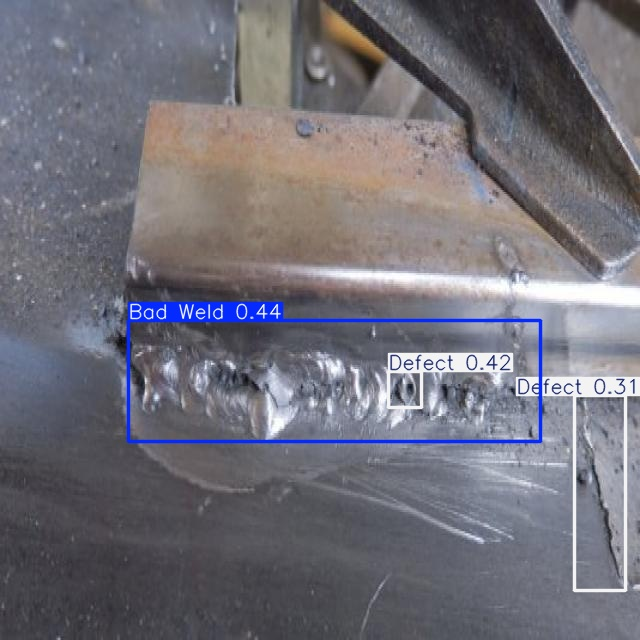

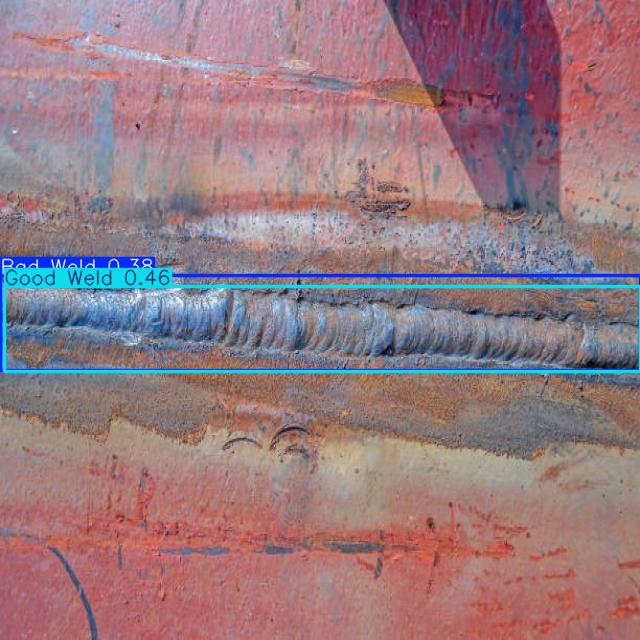

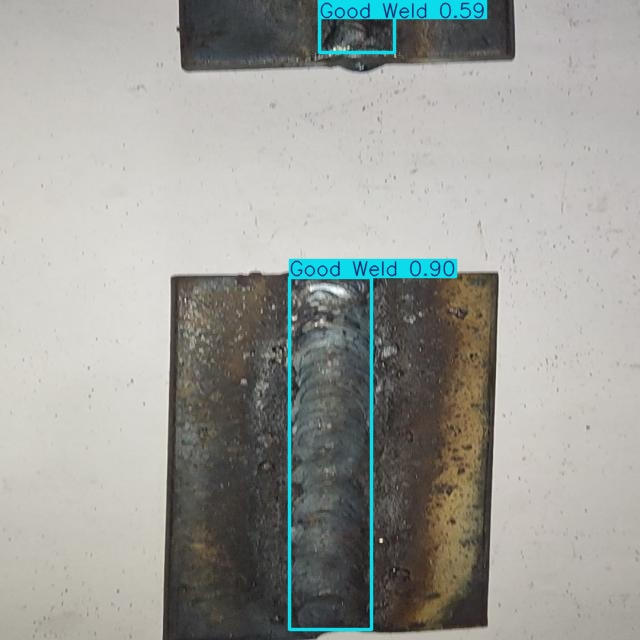

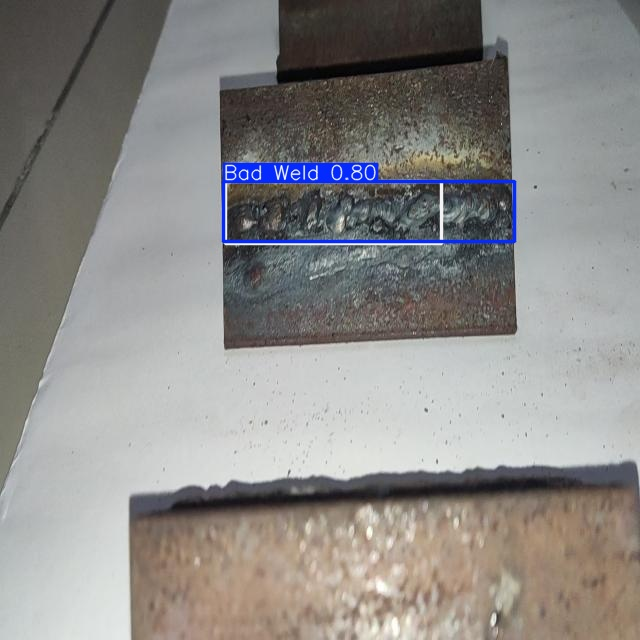

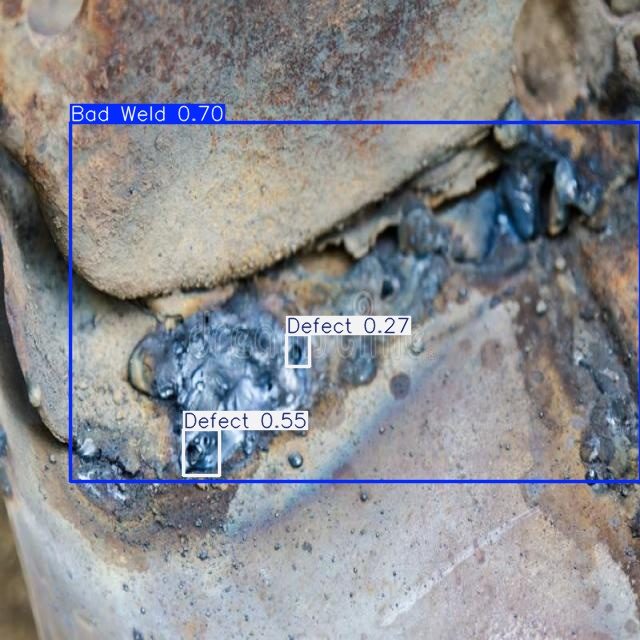

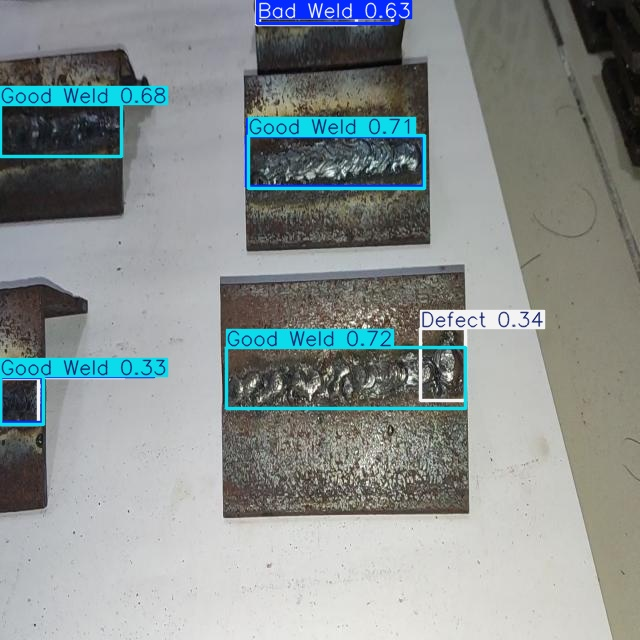

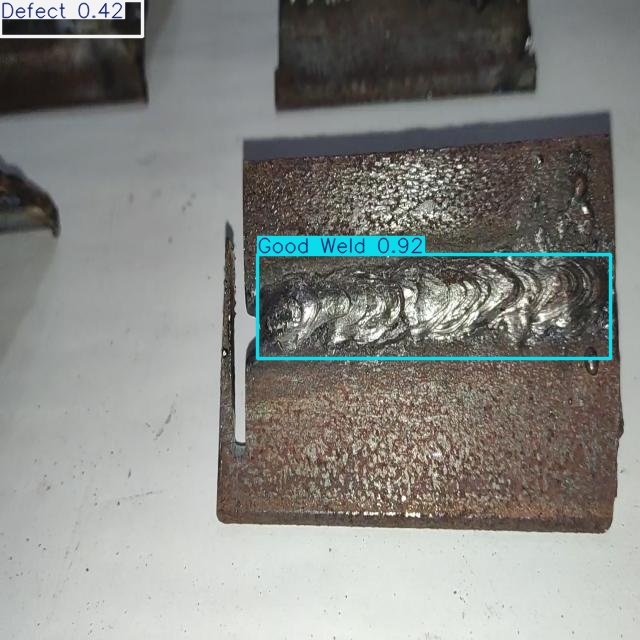

In [9]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


# 7. Model Deploy

Now that our custom model has been trained, it's ready to be downloaded and deployed in an application.

It's possible to zip and download the trained model by running the code blocks below.

The code creates a folder named `my_model`, moves the model weights into it, and renames them from `best.pt` to `my_model.pt`. It also adds the training results in case you want to reference them later. It then zips the folder as `my_model.zip`. Then you can make  the model download from the sidebar

In [ ]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

# 8. Next Steps:



1. Download the my_model.zip
2. Unzip the files in your hardware
3. Open and activate your enviorements
4. Change to the model directory
5. Run `pip install ultralytics` inside your enviorement
6. Download the file to integrate and run the model `curl -o yolo_detect.py https://www.ejtech.io/code/yolo_detect.py`
7. Run the command definig the python script, model, camera and resolution. Per example:
- Run with the webcan: `python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720`
- Run inside a video: `python yolo_detect.py --model my_model.pt --source video_name.mp4 --resolution 1280x720`
